In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db',isolation_level=None) as conn:
        return pd.read_sql(q,conn)

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level==None
        conn.execute(q)

def show_tables():
    q='''
    SELECT
        name,
        type
        
    FROM sqlite_master
    WHERE type IN ("table","view");
    
    '''
    return run_query(q)

show_tables()
       
    

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### US Sales
Break-up of sales by genre in USA

In [4]:
genre_query=''' 
    with customer_usa as 
    (Select 
        c.customer_id,
        c.country,
        il.track_id,
        i.invoice_id,
        il.quantity,
        il.invoice_line_id,
        il.quantity
    from customer c
    inner join invoice i on i.customer_id=c.customer_id
    inner join invoice_line il on il.invoice_id=i.invoice_id
    where c.country='USA'
    )
    Select 
        g.name as genre_name,
        count(cusa.invoice_line_id) track_sold,
        cast(count(cusa.invoice_line_id) as float)/(select count(*) from customer_usa) as percentage_of_total_sales
    from genre g
    inner join track t on g.genre_id=t.genre_id
    inner join customer_usa cusa on cusa.track_id=t.track_id
    group by 1 order by 2 desc
    '''
genre_sales_usa=run_query(genre_query)
genre_sales_usa

,genre_name,track_sold,percentage_of_total_sales
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


### Create HBAR for this table

### Employee Sales target

Sales value attribution for each support representative

In [5]:
query='''
select 
    e.employee_id,e.first_name||" "||e.last_name as employee,
    sum(i.total) as sales
from employee e
inner join customer c on e.employee_id=c.support_rep_id
inner join invoice i on c.customer_id=i.customer_id
group by 1
'''
employee_sales=run_query(query)
employee_sales

,employee_id,employee,sales
0,3,Jane Peacock,1731.51
1,4,Margaret Park,1584.00
2,5,Steve Johnson,1393.92


### Create hbar for this table

### Country-wise sales
-  Distribution of customers by country of origin. 
-  Some countries have just one customer and all such countries are grouped as 'Other'

In [7]:
q='''
with creating_table_country as 
( 
select 
    c.country as country,
    sum(i.total) as total_sales,
    count(distinct(c.customer_id)) as customers,
    sum(i.total)/count(c.customer_id) as value_per_cust
from invoice i 
inner join customer c on i.customer_id=c.customer_id
group by 1
order by 2 desc
)
select 
    country_name country,
    sum(customers) number_of_customers,
    sum(total_sales) total_sales,
    avg(value_per_cust) average_order
from 
    (select 
        ctc.*,
        case
            when ctc.customers<2 then 1
            else 0
        end as sort,
        case 
            when ctc.customers<2 then "Other"
            else ctc.country
        end as country_name
     from creating_table_country as ctc
    )
group by 1    
order by sort,2 desc

'''
sales_by_country=run_query(q)
sales_by_country

,country,number_of_customers,total_sales,average_order
0,USA,13,1040.49,7.942672
1,Canada,8,535.59,7.047237
2,Brazil,5,427.68,7.011148
3,France,5,389.07,7.781400
4,Germany,4,334.62,8.161463
5,United Kingdom,3,245.52,8.768571
6,Czech Republic,2,273.24,9.108000
7,India,2,183.15,8.721429
8,Portugal,2,185.13,6.383793
9,Other,15,1094.94,7.445071


#### Visualizing Sales by country
(This is incomplete.To be worked on)

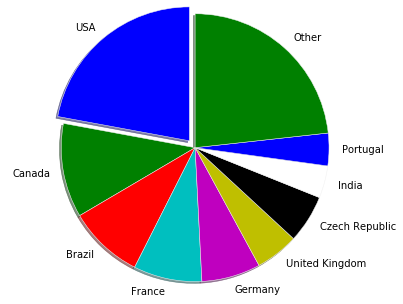

In [8]:
fig,ax=plt.subplots()
ax.axis('equal')
ex=[0]*len(sales_by_country["country"])
ex[0]=0.1
plt.pie(sales_by_country["total_sales"],
        explode=ex,
        labels=sales_by_country["country"],
        startangle=90,radius=1.5,shadow=True);

### Album purchase vs. Individual track purchase

Do customers purchase tracks by buying albums as whole, or do they prefer to pick-n-choose and purchase individual tracks?
If customers prefer the latter way of shopping, should the company just buy the highest selling tracks from each album, from record labels, and do away with stocking albums altogether ?

Below query computes and shows the percentage of sales made as complete-album-purchase vs. individual-track-purchase.
Album-purchases make close to 1/5th of total revenues (~19%).
Based on this figure alone, the company should NOT discontinue stocking albums. 


In [12]:
q='''
with get_tracks as
    (
    Select 
        i.invoice_id invoice_id,
        i.customer_id,
        t.track_id as track_id,
        a.album_id as album_id
    from invoice i
    inner join invoice_line il on i.invoice_id=il.invoice_id
    inner join track t on il.track_id=t.track_id
    inner join album a on a.album_id=t.album_id
    ),

tracks_per_album as
    (
    Select 
        count(distinct t.track_id) as num_of_tracks,
        a.album_id as album_id
    from album a 
    inner join track t on a.album_id=t.album_id
    group by 2
    ),

categorization as 
(
select 
    invoice_id,
    case
        when 
        (select count(distinct track_id) 
        from get_tracks gt where gt.invoice_id=gt2.invoice_id
        group by album_id 
        except
        select num_of_tracks 
        from tracks_per_album tpa
        inner join get_tracks gt on tpa.album_id=gt.album_id        
        where gt.invoice_id=gt2.invoice_id
        group by gt.album_id) is null 
         
        AND
         
        (select num_of_tracks 
         from tracks_per_album tpa
         inner join get_tracks gt on tpa.album_id=gt.album_id        
         where gt.invoice_id=gt2.invoice_id
         group by gt.album_id 
         except
         select count(distinct track_id) 
         from get_tracks gt
         where gt.invoice_id=gt2.invoice_id
         group by album_id ) is Null then "Yes"
          
          else "No"
    end as album_purchase
    
from get_tracks gt2 group by 1
)
select 
    album_purchase,
    count(invoice_id) as number_of_invoices,
    cast(count(invoice_id) as float)/(select count(*) from categorization) as percentage
from categorization
group by 1


'''
run_query(q)

,album_purchase,number_of_invoices,percentage
0,No,500,0.814332
1,Yes,114,0.185668
